In [1]:
import sys
sys.path.append('../../../self_learning_with_venn_abers_predictors/')

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.autograd import Variable
from collections import OrderedDict
import tensorflow as tf

from python_code.neural_net import SimpleNeuralNet, SimpleNeuralNetCredal
from python_code.utils import MyDataset, plot_decision_boundary

2023-02-02 14:51:29.518184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth

In [3]:
df = pd.read_csv("../../data/australian.dat", sep="\s+", header=None)
df.columns = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12", "X13", "X14", "target"]
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,target
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [4]:
scale = StandardScaler()
columns = df.columns
y = df["target"].copy()
df = pd.DataFrame(scale.fit_transform(df))
df.columns = columns
df["target"] = y.copy()
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,target
0,0.688737,-0.801052,1.347111,0.542950,-0.916282,-0.347965,-0.190906,-1.047504,-0.864196,-0.493887,1.087908,0.237828,-0.488358,0.037380,0
1,-1.451933,-0.751240,0.450548,0.542950,0.170499,-0.347965,-0.615536,-1.047504,-0.864196,-0.493887,-0.919195,0.237828,-0.139591,-0.195413,0
2,-1.451933,-0.167856,-0.604823,-1.783978,-0.916282,-0.347965,-0.291083,-1.047504,-0.864196,-0.493887,1.087908,0.237828,0.557943,-0.195413,0
3,-1.451933,-0.835667,1.355152,-1.783978,-0.644587,-0.850257,-0.664877,0.954650,1.157144,1.769760,1.087908,0.237828,-1.069637,-0.195413,1
4,0.688737,-0.962306,0.685745,0.542950,-0.372892,-0.347965,-0.078768,0.954650,1.157144,2.387119,-0.919195,0.237828,-0.720870,-0.165066,1


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("target", axis=1), df["target"], train_size=0.8, random_state=35)
X_train, X_calib, Y_train, Y_calib = train_test_split(X_train, Y_train, train_size=0.95, random_state=35)
trainset = pd.DataFrame(X_train, columns=df.drop("target", axis=1).columns)
trainset["target"] = Y_train
trainset.iloc[80:, trainset.columns.get_loc("target")] = np.NaN 
known_train = trainset.iloc[0:80]
unknow_train = trainset.iloc[80:]
known_train.shape, unknow_train.shape, X_calib.shape, X_test.shape

((80, 15), (444, 15), (28, 14), (138, 14))

# Self Learning strategy 1

In [6]:
class SelfLearning():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs,
        verbose
    ):
        self.model_convergence_epochs = model_convergence_epochs
        torch.manual_seed(3)
        self.model = SimpleNeuralNet(clipping_value=0.01, n_input_units=14, n_hidden_units=4)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.005, verbose=verbose)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, batch_adding=5):
        while len(self.unknown_x_train) >= batch_adding:
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            self.unknown_x_train.sort_values("y", ascending=False, inplace=True)
            self.unknown_x_train["y"] = self.unknown_x_train["y"].apply(lambda x: 1 if x>0.5 else 0)
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train.iloc[0:batch_adding].drop(["y"], axis=1),
                    self.unknown_x_train.iloc[-batch_adding:].drop(["y"], axis=1)
                ]
            )
            self.known_y_train = pd.concat(
                [
                    self.known_y_train,
                    self.unknown_x_train.iloc[0:batch_adding]["y"],
                    self.unknown_x_train.iloc[-batch_adding:]["y"]
                ]
            )
            self.unknown_x_train = self.unknown_x_train.iloc[batch_adding:-batch_adding].drop(["y"], axis=1)
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.005, verbose=False)
        self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
        self.unknown_x_train["y"] = self.unknown_x_train["y"].apply(lambda x: 1 if x>0.5 else 0)
        self.known_x_train = pd.concat(
            [
                self.known_x_train,
                self.unknown_x_train.drop(["y"], axis=1),
            ]
        )
        self.known_y_train = pd.concat(
            [
                self.known_y_train,
                self.unknown_x_train["y"],
            ]
        )
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.005, verbose=False)
        predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
        self.accuracies.append(accuracy_score(validation_y, predictions))

Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.5375
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.5375
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6555 - accuracy: 0.5375
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.5375
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.5375
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.5375
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.5375
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6488 - accuracy: 0.5375
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.5375
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.5500


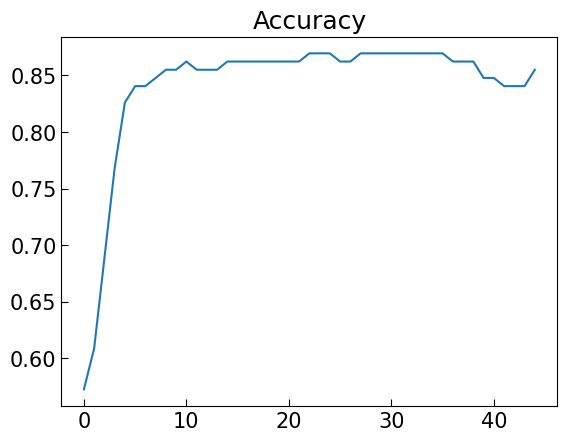

In [7]:
test1 = SelfLearning(
    known_x_train=known_train.drop(["target"], axis=1),
    known_y_train=known_train["target"],
    unknown_x_train=unknow_train.drop(["target"], axis=1),
    model_convergence_epochs=10,
    verbose=True
)
test1.learning(validation_x=X_test, validation_y=Y_test, batch_adding=5)
sns.lineplot(x=[i for i in range(len(test1.accuracies))], y=test1.accuracies).set(title="Accuracy")
plt.show()

# Self Learning strategy 2

In [8]:
class SelfLearningWithSoft():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs,
        verbose
    ):
        self.model_convergence_epochs = model_convergence_epochs
        torch.manual_seed(3)
        self.model = SimpleNeuralNet(clipping_value=0.01, n_input_units=14, n_hidden_units=4)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        self.length_known = len(self.known_y_train)
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.005, verbose=verbose)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, n_epochs=10, verbose=True):
        for epochs in range(n_epochs):
            self.known_y_train = self.known_y_train.apply(lambda x: x-0.001 if x==1 else x+0.001 if x==0 else x)
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train.drop(["y"], axis=1),
                ]
            ).drop_duplicates()
            if epochs == 0:
                self.known_y_train = pd.concat(
                    [
                        self.known_y_train,
                        self.unknown_x_train["y"],
                    ]
                )
            else:
                self.known_y_train[self.length_known:] = self.unknown_x_train["y"]
            self.unknown_x_train = self.unknown_x_train.drop(["y"], axis=1)
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            if verbose:
                print(f"Accuracy epochs {epochs}: {accuracy_score(validation_y, predictions)}")
            self.model.fit(
                self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.005, verbose=False, soft=True
            )

Epoch 1/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6581 - accuracy: 0.5375
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6568 - accuracy: 0.5375
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6555 - accuracy: 0.5375
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.5375
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6528 - accuracy: 0.5375
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6515 - accuracy: 0.5375
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6501 - accuracy: 0.5375
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6488 - accuracy: 0.5375
Epoch 9/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.5375
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.5500
Accuracy epochs 0: 0.572463768115942
Ac

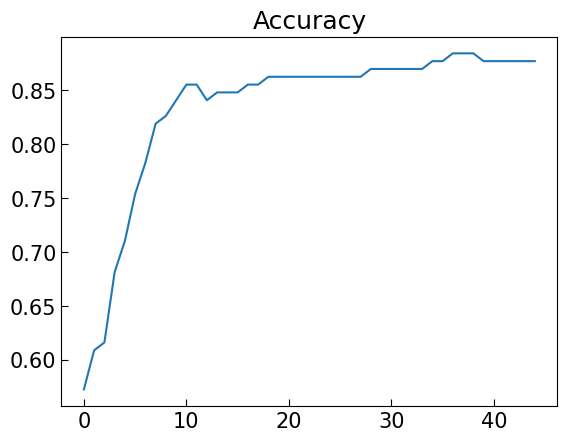

In [9]:
test2 = SelfLearningWithSoft(
    known_x_train=known_train.drop(["target"], axis=1),
    known_y_train=known_train["target"],
    unknown_x_train=unknow_train.drop(["target"], axis=1),
    model_convergence_epochs=10,
    verbose=True
)
test2.learning(validation_x=X_test, validation_y=Y_test, n_epochs=45)
sns.lineplot(x=[i for i in range(len(test2.accuracies))], y=test2.accuracies).set(title="Accuracy")
plt.show()

# Self Learning startegy 3

In [10]:
def venn_abers_pytorch(trained_classifier, calibration_features, test_instance, calibration_labels):
    calibrations = trained_classifier.predict_probas(calibration_features, as_numpy=True, from_numpy=False)
    predictions = trained_classifier.predict_probas(test_instance, as_numpy=True, from_numpy=False)
    interval = []
    scores = pd.DataFrame()
    scores["s"] = calibrations[:, 0]
    scores["y"] = calibration_labels.to_numpy()
    score = pd.DataFrame()
    score["s"] = predictions[:, 0]
    interval = [] 
    
    for i in [0, 1]:
        score["y"] = i
        train = pd.concat([scores, score], ignore_index=True)
        g = IsotonicRegression(y_min=0.001, y_max=0.999, out_of_bounds='clip')
        g.fit(train["s"], train["y"])
        pred = g.predict(score["s"])[0]
        if pred == np.nan:
            print("PROBA PREDICTED: ", predictions)
            print(g.fit_transform(train["s"], train["y"]))
        interval.append(g.predict(score["s"])[0])
    interval = np.array(interval)
    return interval


In [11]:
class SelfLearningUsingVennAbers():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        calib_x_train, 
        calib_y_train,
        model_convergence_epochs,
        verbose
    ):
        self.model_convergence_epochs = model_convergence_epochs
        torch.manual_seed(3)
        self.model = SimpleNeuralNetCredal(clipping_value=0.01, n_input_units=14, n_hidden_units=4)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        self.calib_x_train = calib_x_train
        self.calib_y_train = calib_y_train
        self.length_known = len(self.known_y_train)
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.005, verbose=verbose)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, n_epochs=10, verbose=True):
        self.known_y_train = self.known_y_train.apply(
            lambda x: np.stack(
                [x+0.001, x+0.001] if x == 0 else [x-0.001, x-0.001] if x ==1 else x,
                axis=-1
        ).astype(np.float32))
        for epochs in range(n_epochs):
            self.unknown_x_train["interval"] =  self.unknown_x_train.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train.values.astype(np.float32)),
                    torch.from_numpy(x.values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train.drop("interval", axis=1),
                ]
            ).drop_duplicates()
            if epochs == 0:
                self.known_y_train = pd.concat(
                    [
                        self.known_y_train,
                        self.unknown_x_train["interval"],
                    ]
                )
            else:
                self.known_y_train[self.length_known:] = self.unknown_x_train["interval"]
            
            self.unknown_x_train = self.unknown_x_train.drop("interval", axis=1)
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            if verbose:
                print(f"Accuracy epochs {epochs+1}: {accuracy_score(validation_y, predictions)}")
            self.model.fit(
                self.known_x_train,
                self.known_y_train,
                epochs=self.model_convergence_epochs,
                learning_rate=0.005,
                verbose=False,
                credal=True
            )
            
    
    def predict_probas(self, x_test):
        probs = self.model.predict_probas(x_test, from_numpy=True, as_numpy=True)
        return probs
    
    def predict_probas_interval(self, x_test):
        returns = x_test.copy()
        returns["interval"] = returns.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train.values.astype(np.float32)),
                    torch.from_numpy(x.values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
        return returns

Epoch 1/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6581 - accuracy: 0.5375
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.5375
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6555 - accuracy: 0.5375
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.5375
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6528 - accuracy: 0.5375
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6515 - accuracy: 0.5375
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6501 - accuracy: 0.5375
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.5375
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.5375
Epoch 10/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6460 - accuracy: 0.5500
Accuracy epochs 1: 0.572463768115942
Ac

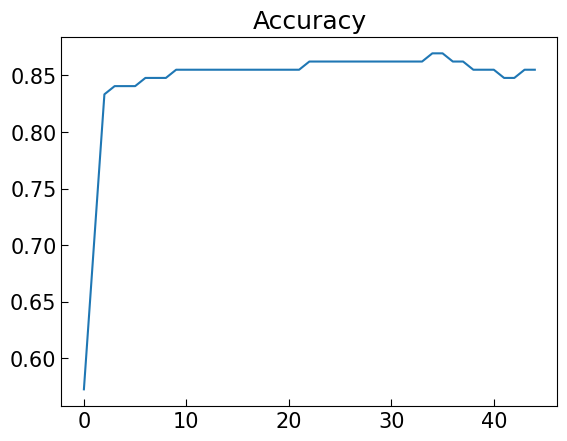

In [12]:
test3 = SelfLearningUsingVennAbers(
    known_x_train=known_train.drop(["target"], axis=1),
    known_y_train=known_train["target"],
    unknown_x_train=unknow_train.drop(["target"], axis=1),
    calib_x_train=X_calib,
    calib_y_train=Y_calib,
    model_convergence_epochs=10,
    verbose=True
)
test3.learning(validation_x=X_test, validation_y=Y_test, n_epochs=45)
sns.lineplot(x=[i for i in range(len(test3.accuracies))], y=test3.accuracies).set(title="Accuracy")
plt.show()

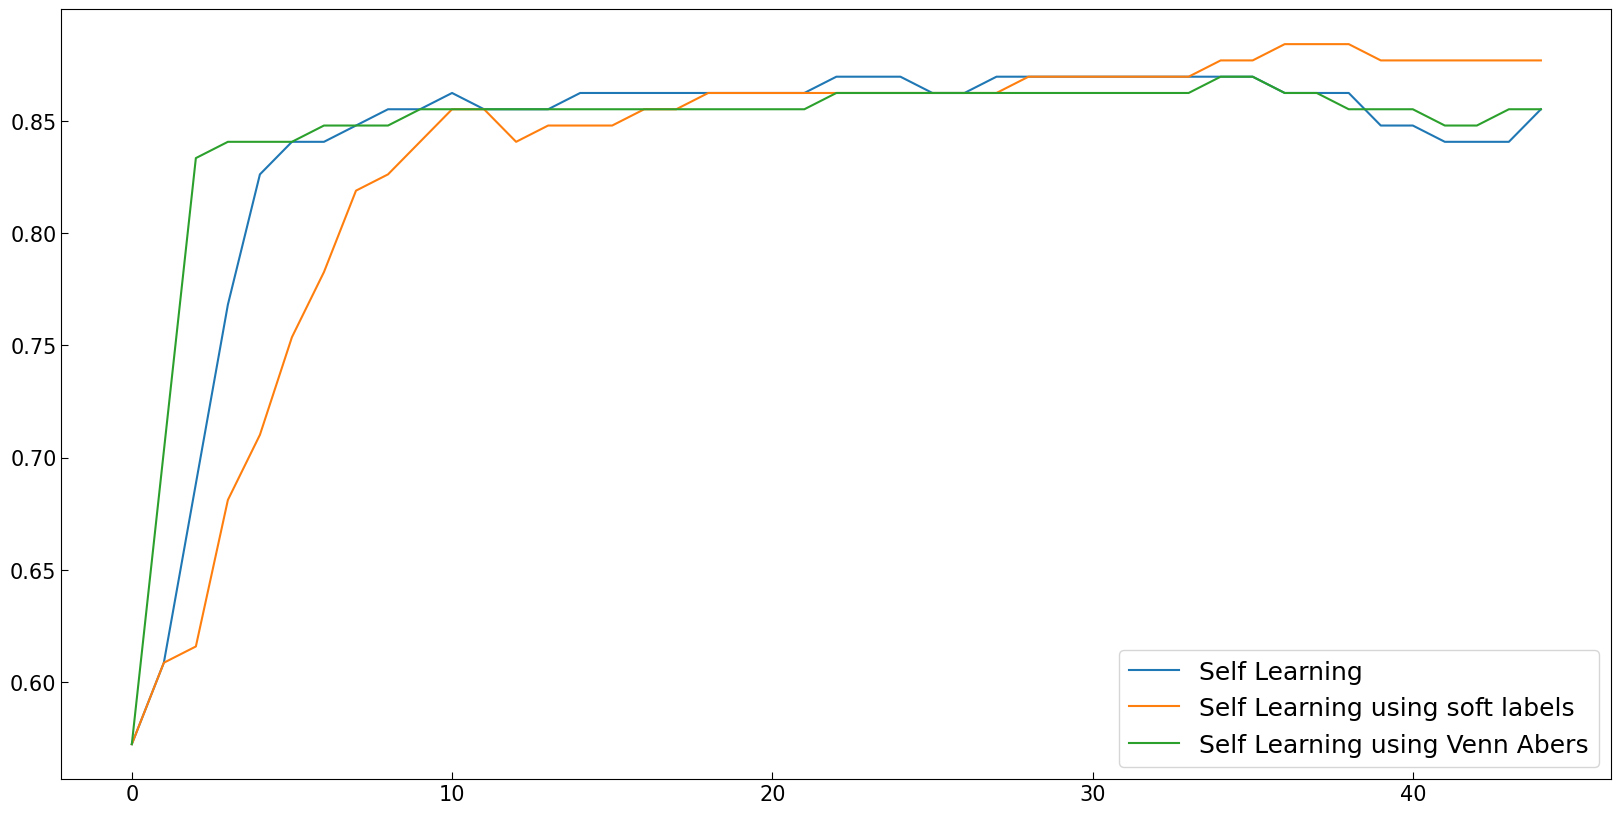

In [13]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=[i for i in range(len(test1.accuracies))], y=test1.accuracies, markers=True, label="Self Learning")
sns.lineplot(x=[i for i in range(len(test2.accuracies))], y=test2.accuracies, markers=True, label="Self Learning using soft labels")
sns.lineplot(x=[i for i in range(len(test3.accuracies))], y=test3.accuracies, markers=True, label="Self Learning using Venn Abers")
plt.show()

0.8342995169082127
0.8212560386473432
0.8495974235104672


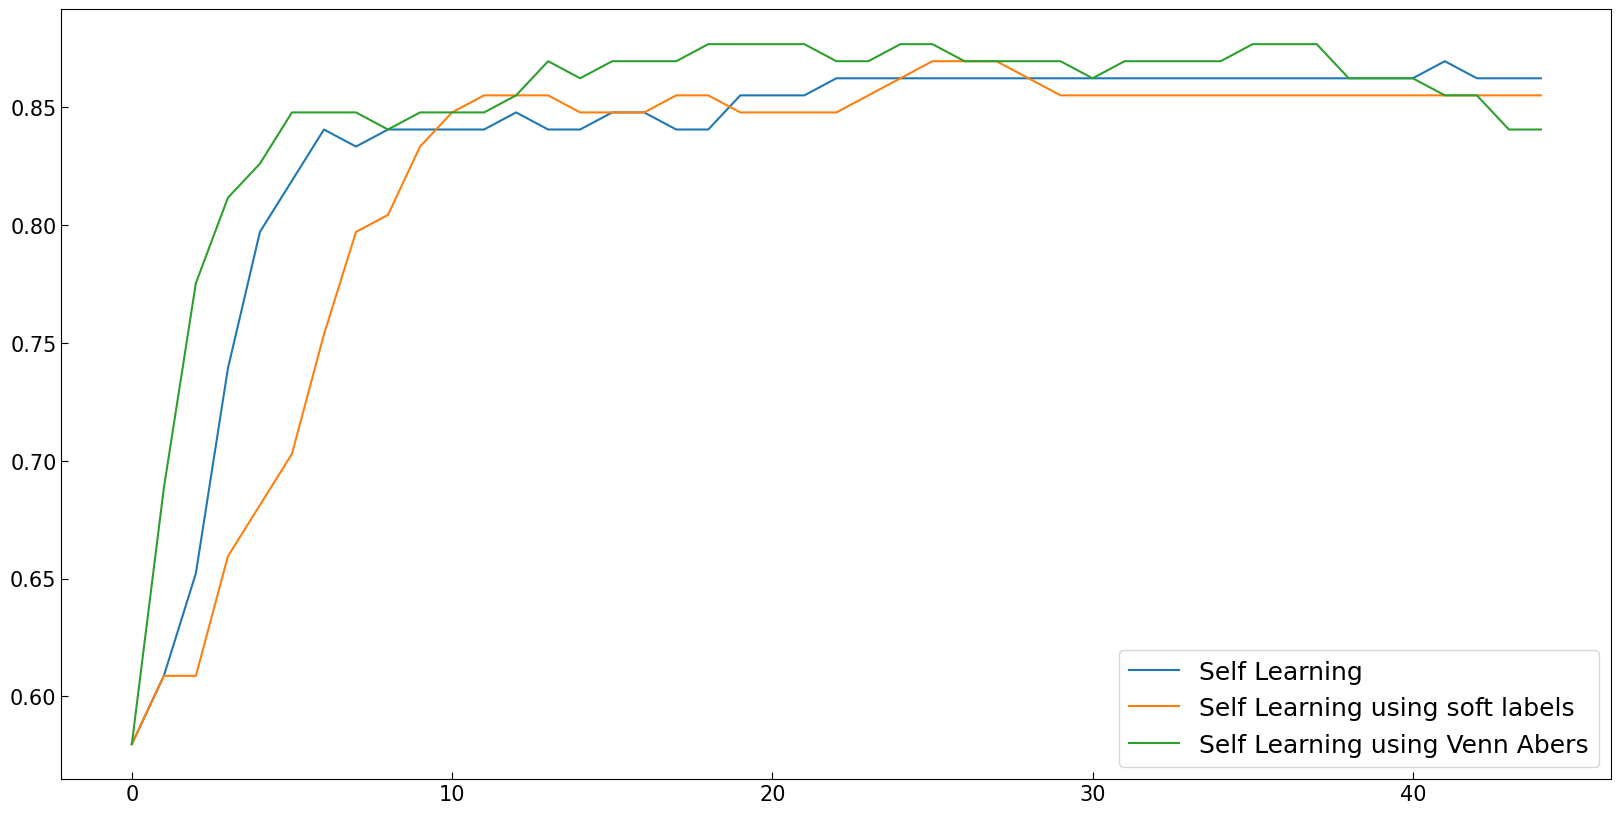

0.8531400966183574
0.8405797101449276
0.8615136876006443


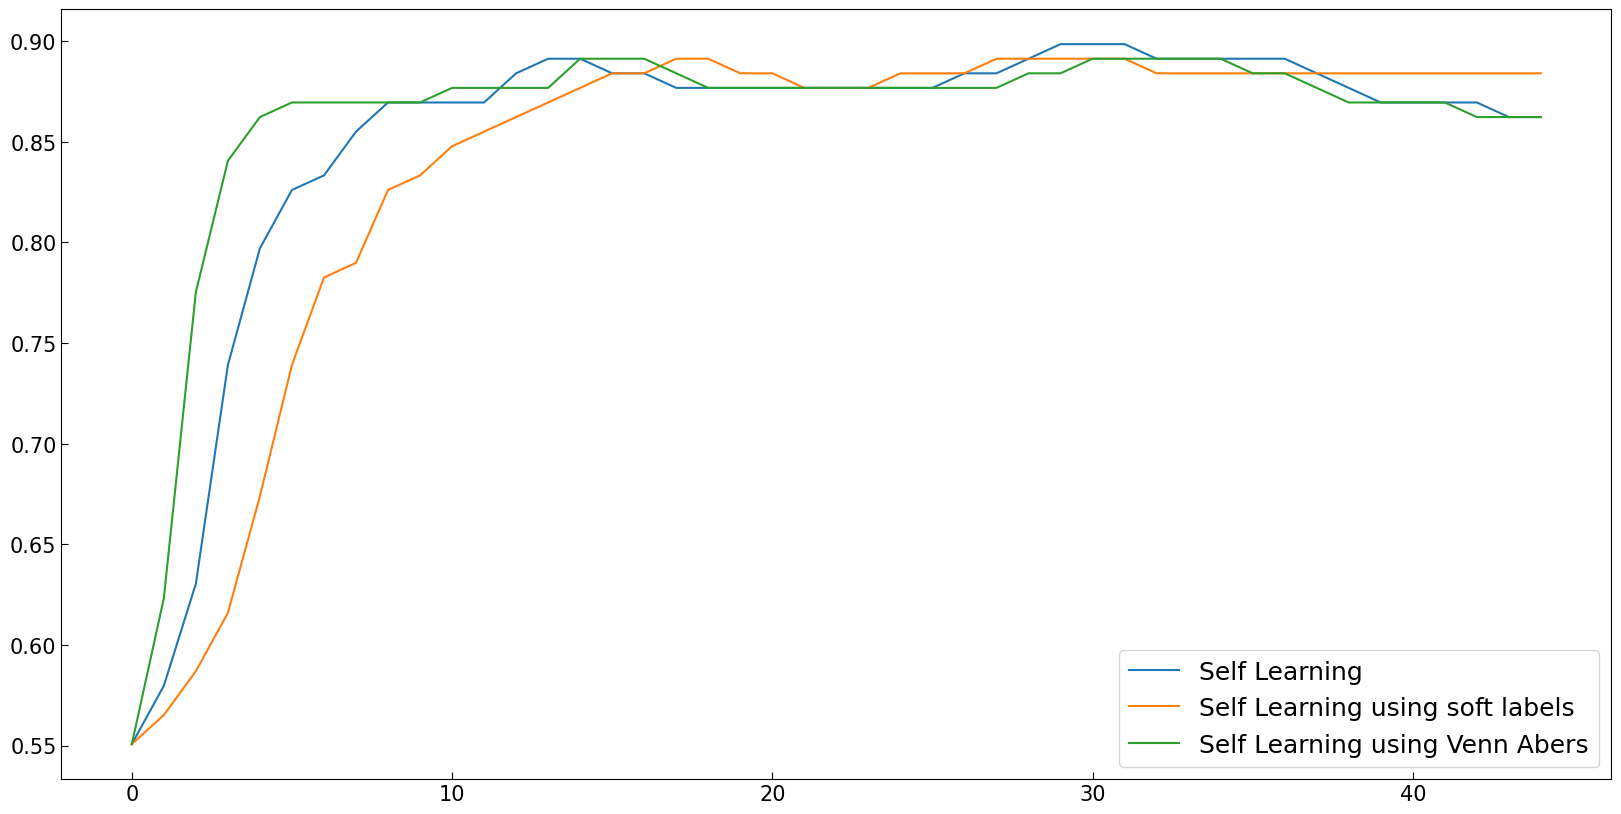

0.8257648953301127
0.8106280193236717
0.8362318840579712


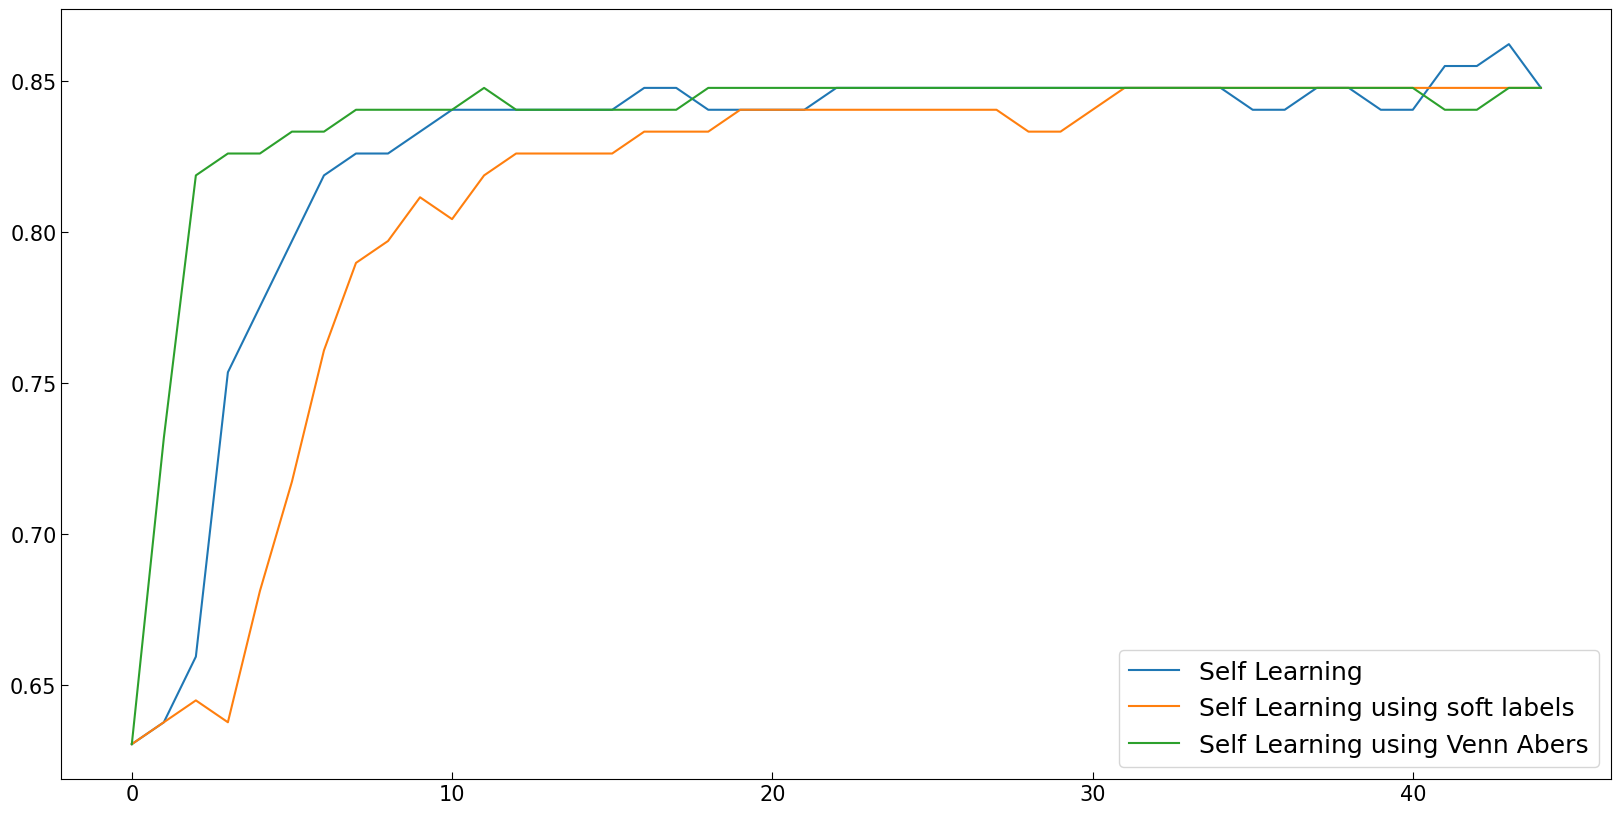

0.8151368760064414
0.7644122383252818
0.8344605475040259


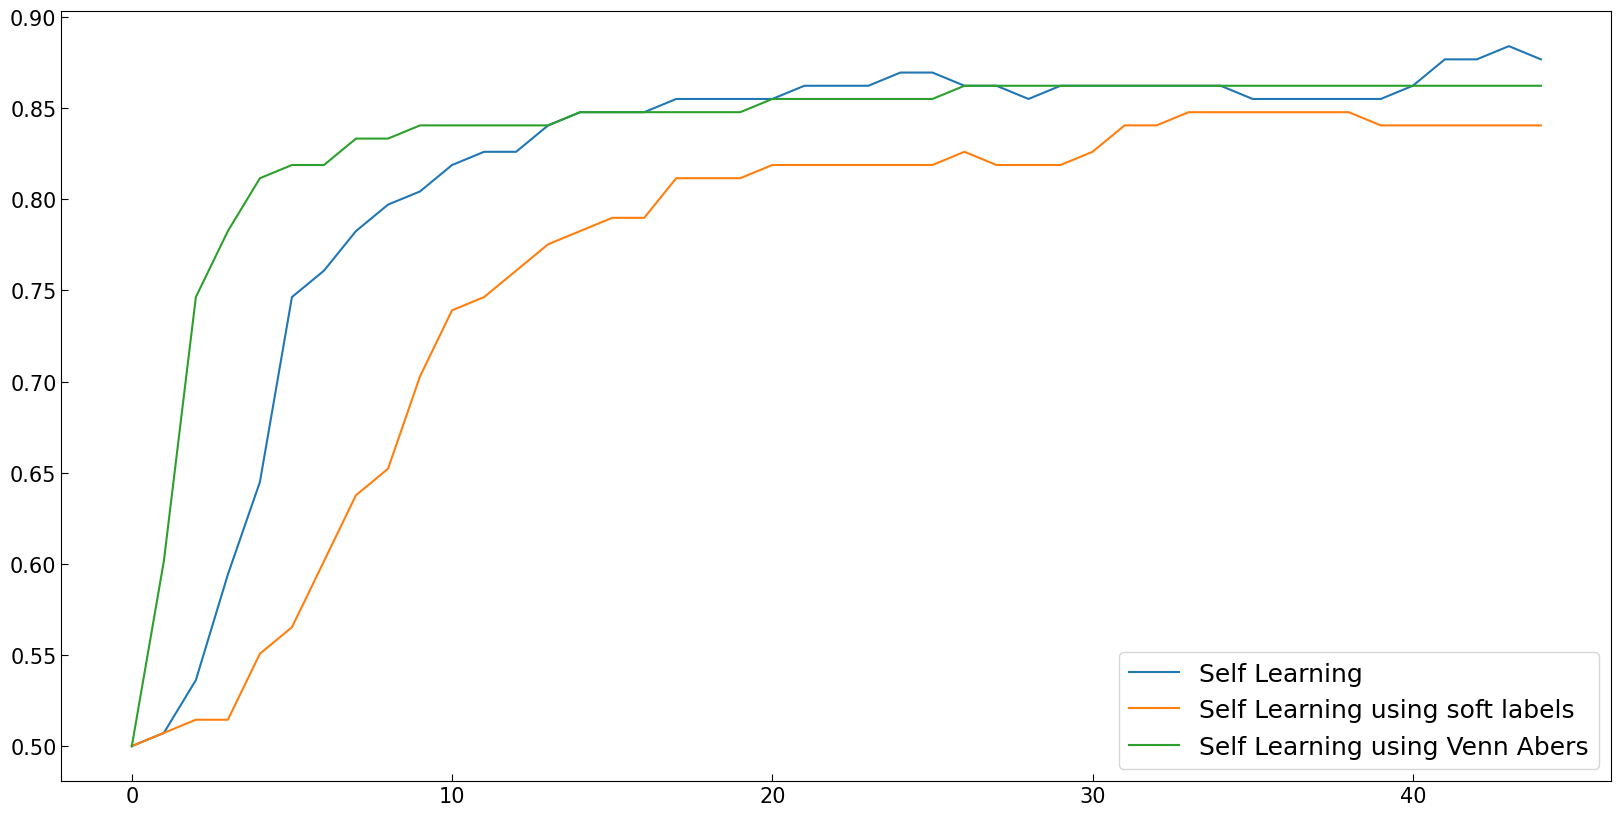

0.8396135265700484
0.8225442834138488
0.8417069243156201


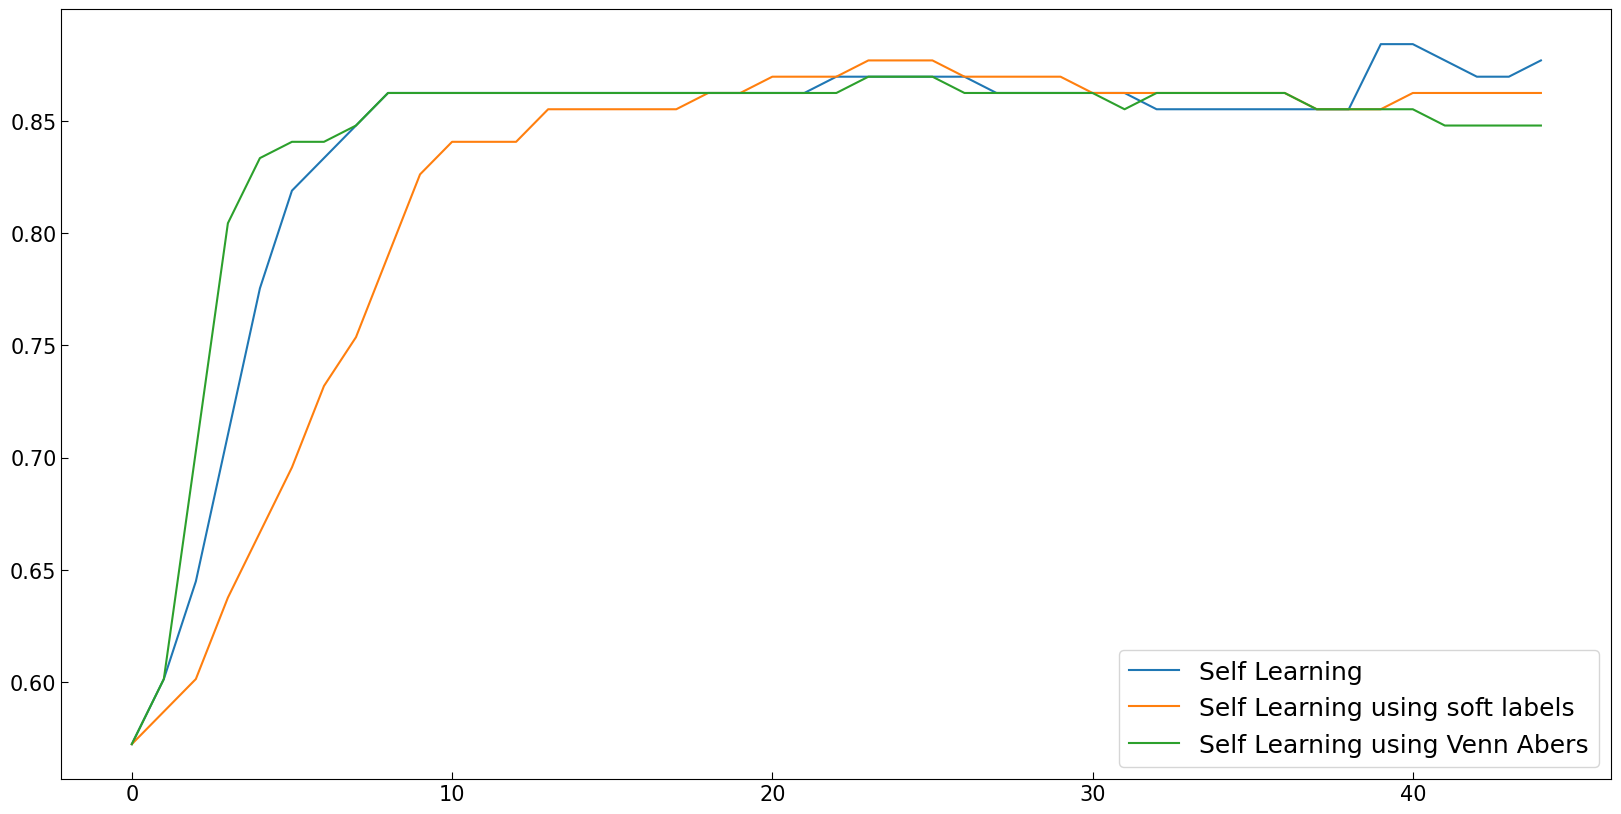

0.8512077294685991
0.8388083735909825
0.8542673107890502


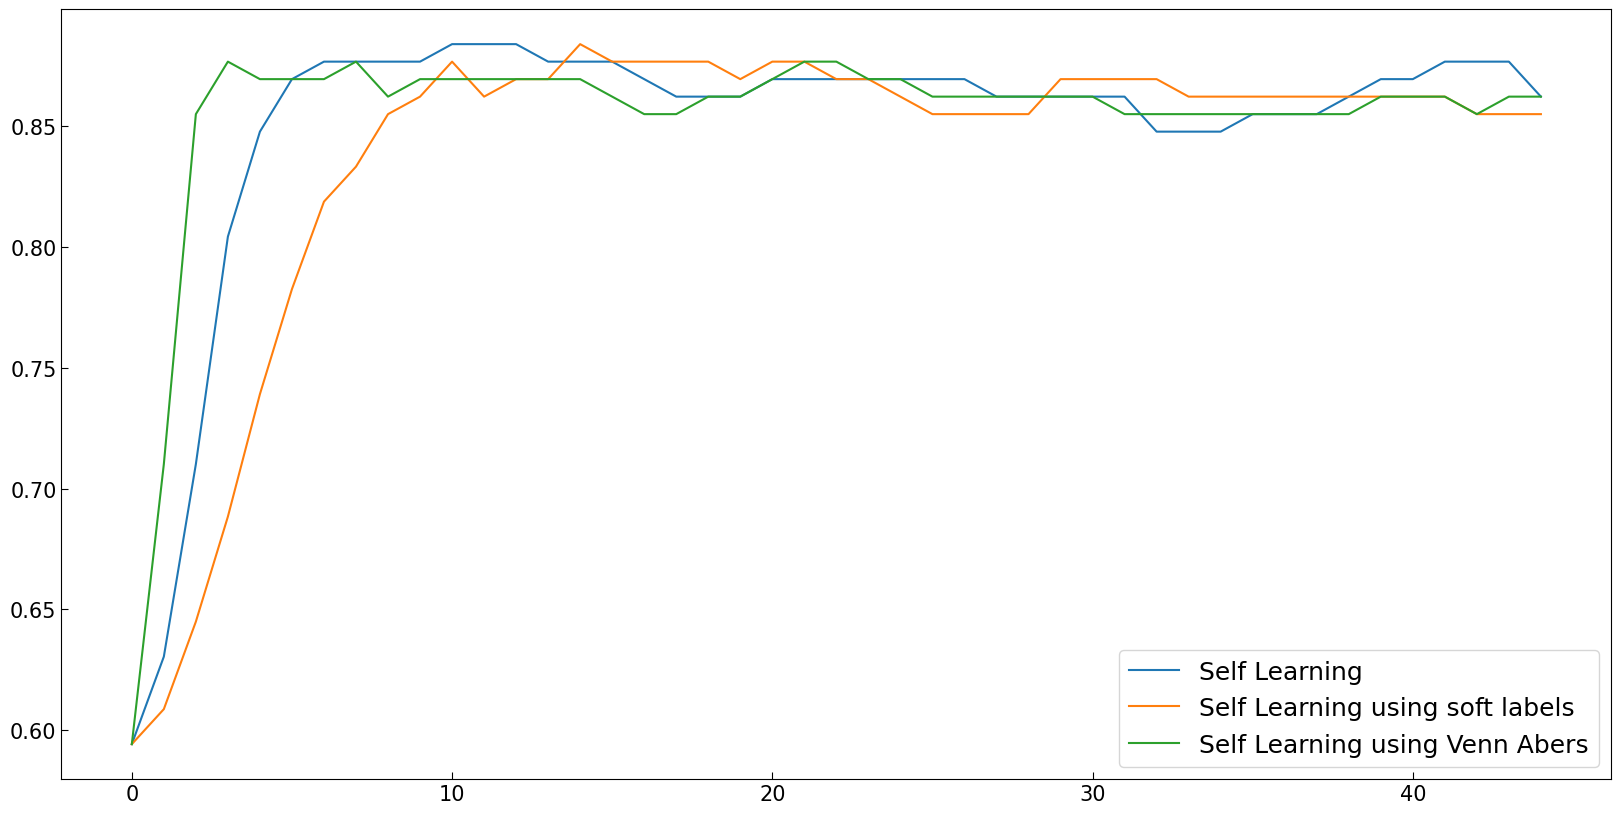

0.8219001610305958
0.7982286634460548
0.8223832528180356


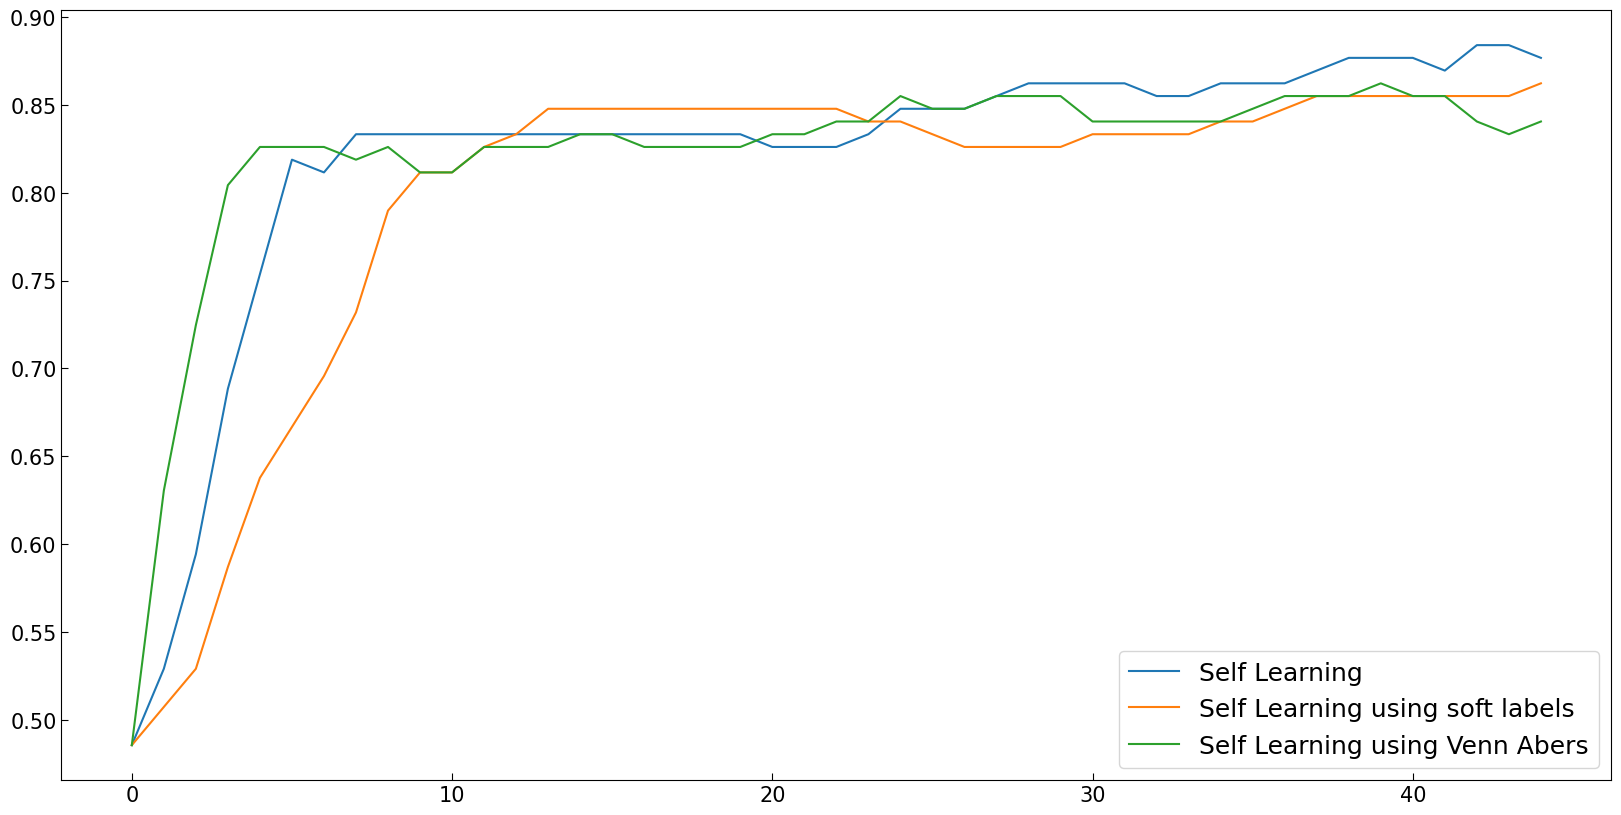

0.7826086956521736
0.7856682769726251
0.7996779388083733


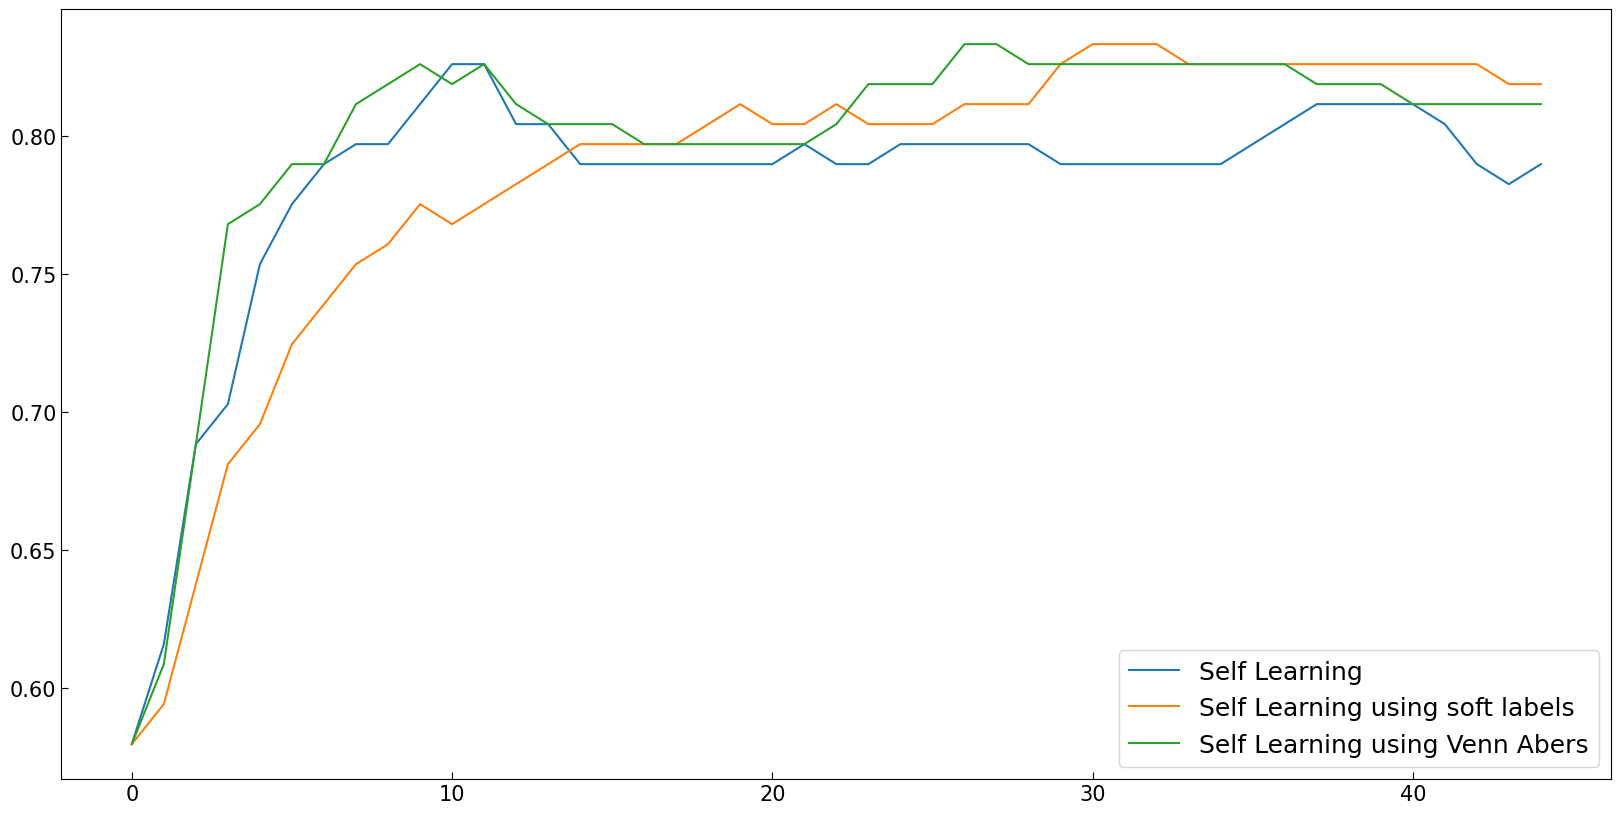

0.8241545893719806
0.7914653784219003
0.8169082125603866


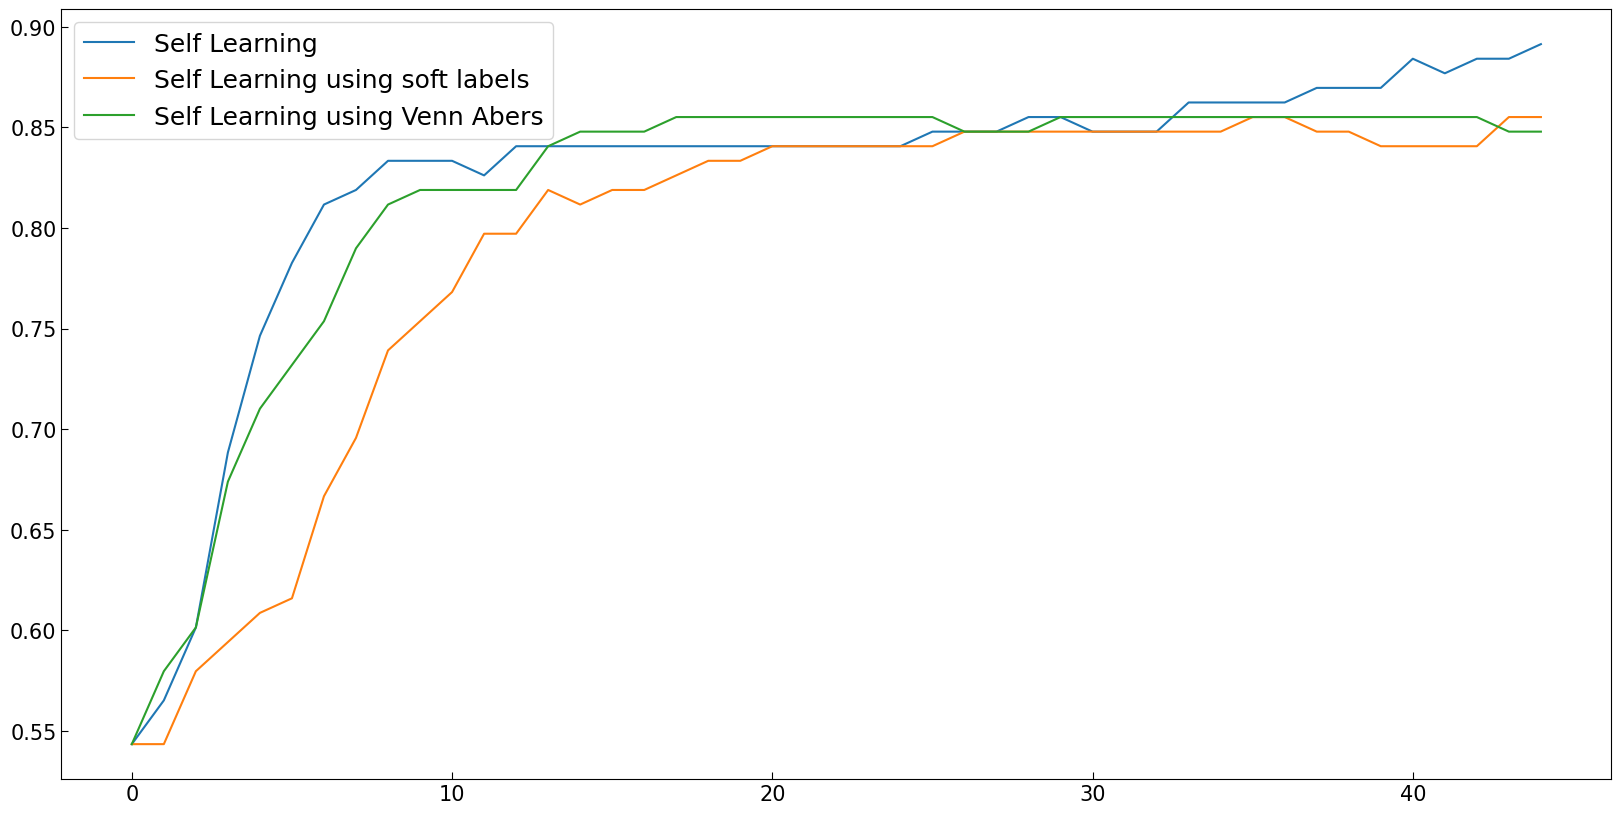

0.8410628019323674
0.8338164251207729
0.8460547504025766


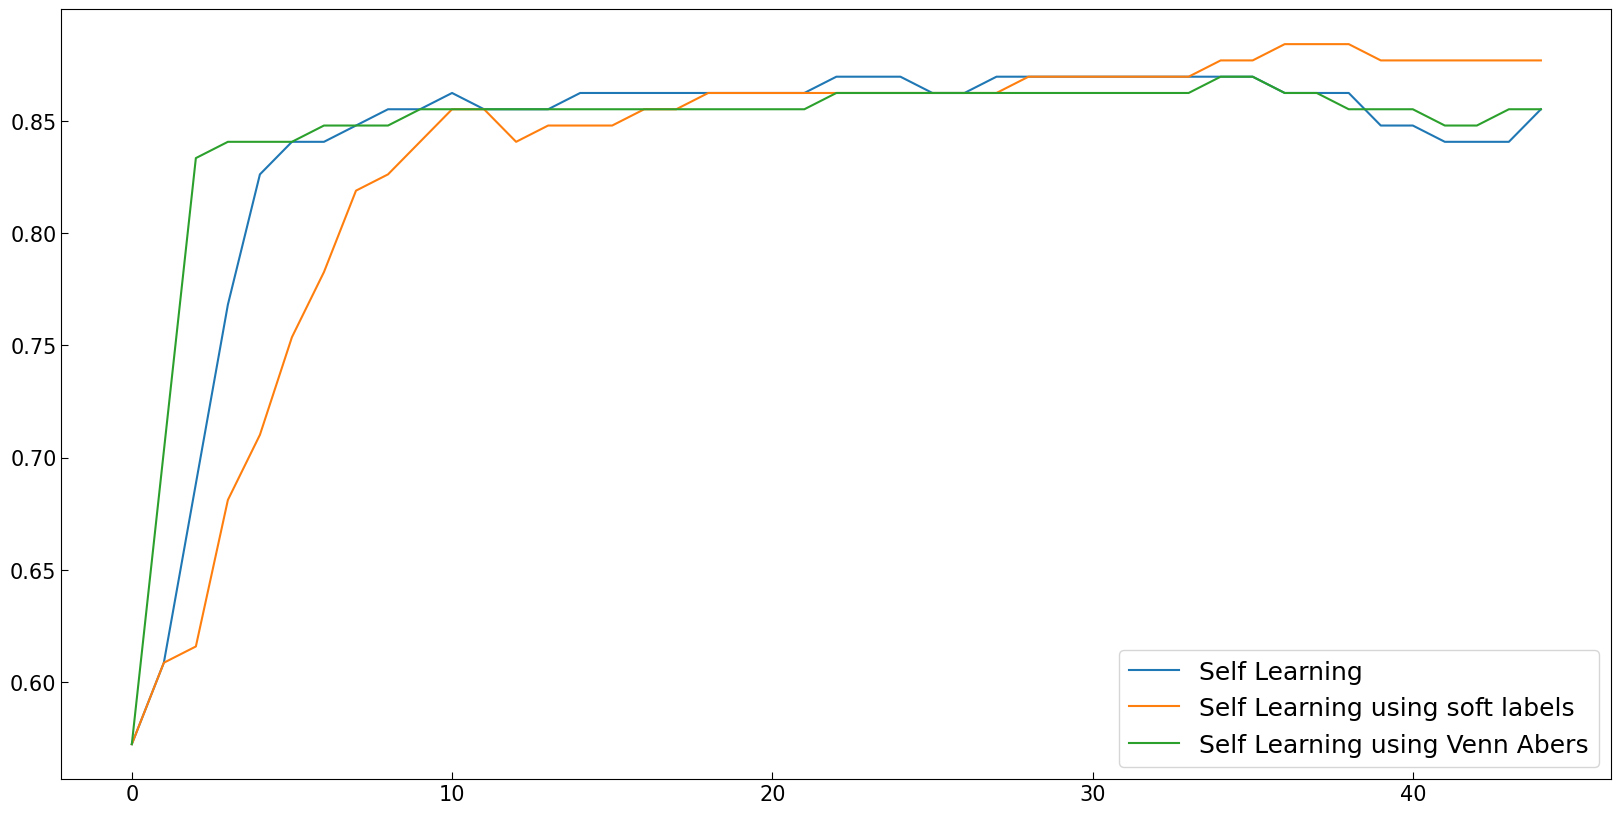

In [19]:
sl_acc = []
sl_sl_acc = []
sl_va_acc = []
for i in [525, 195, 909, 654, 375, 270, 124, 290, 14, 35]:
    df = pd.read_csv("../../data/australian.dat", sep="\s+", header=None)
    df.columns = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12", "X13", "X14", "target"]
    scale = StandardScaler()
    columns = df.columns
    y = df["target"].copy()
    df = pd.DataFrame(scale.fit_transform(df))
    df.columns = columns
    df["target"] = y.copy()
    
    X_train, X_test, Y_train, Y_test = train_test_split(df.drop("target", axis=1), df["target"], train_size=0.8, random_state=i)
    X_train, X_calib, Y_train, Y_calib = train_test_split(X_train, Y_train, train_size=0.95, random_state=i)
    trainset = pd.DataFrame(X_train, columns=df.drop("target", axis=1).columns)
    trainset["target"] = Y_train
    trainset.iloc[80:, trainset.columns.get_loc("target")] = np.NaN 
    known_train = trainset.iloc[0:80]
    unknow_train = trainset.iloc[80:]
    
    test1 = SelfLearning(
        known_x_train=known_train.drop(["target"], axis=1),
        known_y_train=known_train["target"],
        unknown_x_train=unknow_train.drop(["target"], axis=1),
        model_convergence_epochs=10,
        verbose=False
    )
    test1.learning(validation_x=X_test, validation_y=Y_test, batch_adding=5)
    print(np.mean(test1.accuracies))
    
    test2 = SelfLearningWithSoft(
        known_x_train=known_train.drop(["target"], axis=1),
        known_y_train=known_train["target"],
        unknown_x_train=unknow_train.drop(["target"], axis=1),
        model_convergence_epochs=10,
        verbose=False
    )
    test2.learning(validation_x=X_test, validation_y=Y_test, n_epochs=45, verbose=False)
    print(np.mean(test2.accuracies))
    
    test3 = SelfLearningUsingVennAbers(
        known_x_train=known_train.drop(["target"], axis=1),
        known_y_train=known_train["target"],
        unknown_x_train=unknow_train.drop(["target"], axis=1),
        calib_x_train=X_calib,
        calib_y_train=Y_calib,
        model_convergence_epochs=10,
        verbose=False
    )
    test3.learning(validation_x=X_test, validation_y=Y_test, n_epochs=45, verbose=False)
    print(np.mean(test3.accuracies))
    
    plt.figure(figsize=(20, 10))
    sns.lineplot(x=[i for i in range(len(test1.accuracies))], y=test1.accuracies, markers=True, label="Self Learning")
    sns.lineplot(x=[i for i in range(len(test2.accuracies))], y=test2.accuracies, markers=True, label="Self Learning using soft labels")
    sns.lineplot(x=[i for i in range(len(test3.accuracies))], y=test3.accuracies, markers=True, label="Self Learning using Venn Abers")
    plt.show()
    
    sl_acc.append(test1.accuracies)
    sl_sl_acc.append(test2.accuracies)
    sl_va_acc.append(test3.accuracies)

In [41]:
sl_acc_mean = []
sl_sl_acc_mean = []
sl_va_acc_mean = []

for i in range(30):
    sum_acc_sl = 0
    sum_acc_sl_sl = 0
    sum_acc_sl_va = 0
    for j in range(10):
        sum_acc_sl += sl_acc[j][i]
        sum_acc_sl_sl += sl_sl_acc[j][i]
        sum_acc_sl_va += sl_va_acc[j][i]
    sl_acc_mean.append(sum_acc_sl/10)
    sl_sl_acc_mean.append(sum_acc_sl_sl/10)
    sl_va_acc_mean.append(sum_acc_sl_va/10)

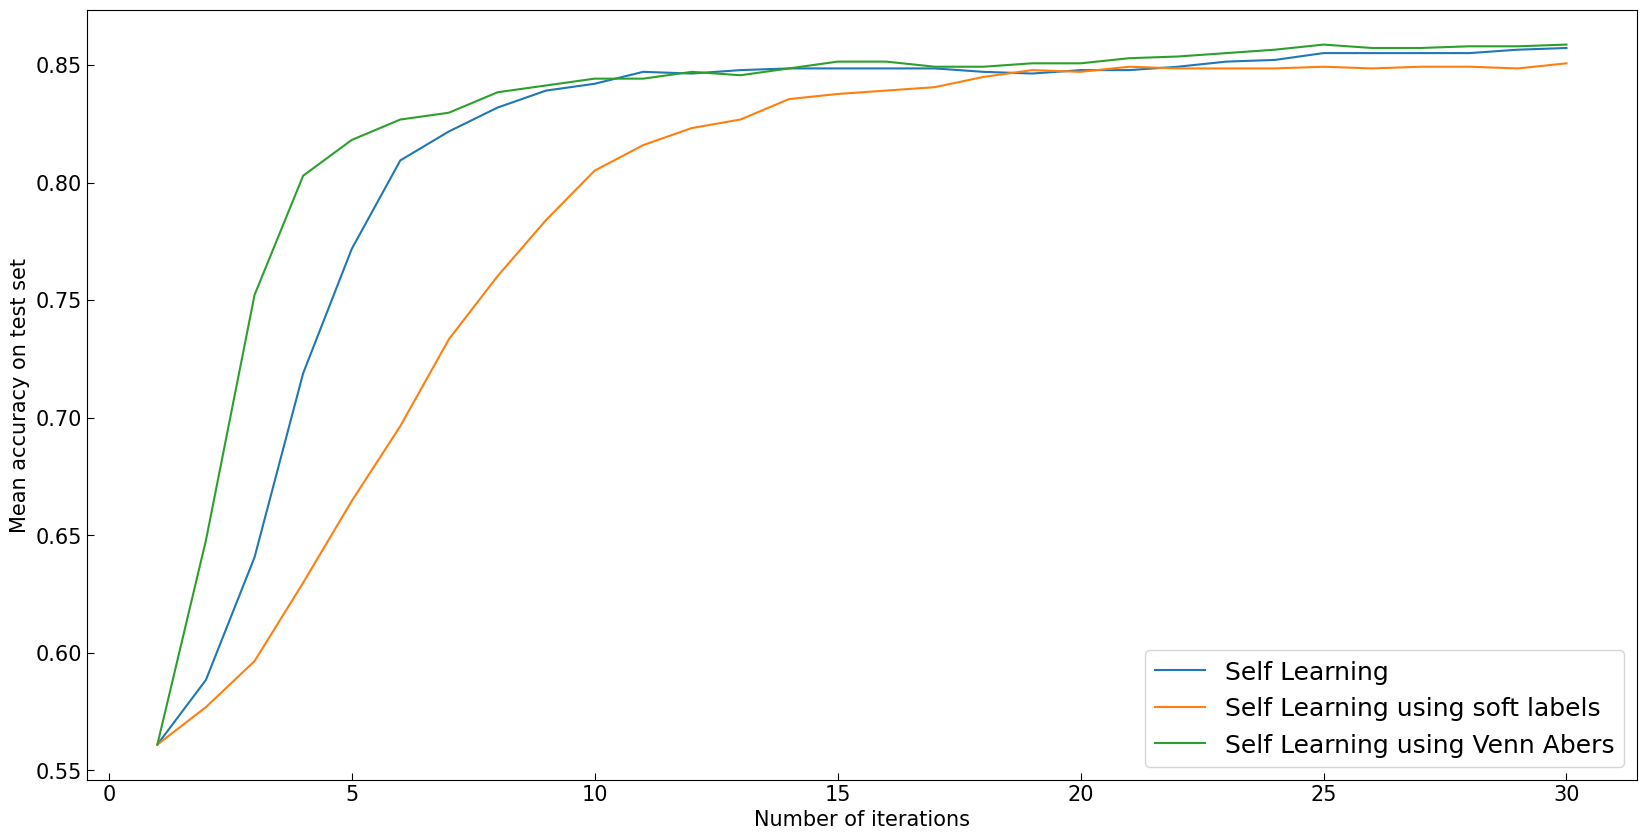

In [42]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=[i for i in range(1, len(sl_acc_mean)+1)], y=sl_acc_mean, markers=True, label="Self Learning")
sns.lineplot(x=[i for i in range(1, len(sl_sl_acc_mean)+1)], y=sl_sl_acc_mean, markers=True, label="Self Learning using soft labels")
sns.lineplot(x=[i for i in range(1, len(sl_va_acc_mean)+1)], y=sl_va_acc_mean, markers=True, label="Self Learning using Venn Abers")
plt.xlabel("Number of iterations")
plt.ylabel("Mean accuracy on test set")
plt.show()

In [43]:
np.mean(sl_acc_mean), np.mean(sl_sl_acc_mean), np.mean(sl_va_acc_mean)

(0.8145410628019326, 0.7885507246376815, 0.8272222222222223)

In [44]:
sl_30_acc = []
sl_sl_30_acc = []
sl_va_30_acc = []

for i in range(10):
    sl_30_acc.append(sl_acc[i][29])
    sl_sl_30_acc.append(sl_sl_acc[i][29])
    sl_va_30_acc.append(sl_va_acc[i][29])

np.std(sl_30_acc), np.std(sl_sl_30_acc), np.std(sl_va_30_acc)

(0.025732291166035818, 0.02296083988080413, 0.014218418021991735)

In [45]:
sl_acc_mean[29], sl_sl_acc_mean[29], sl_va_acc_mean[29]

(0.8572463768115941, 0.8507246376811594, 0.8586956521739131)